In [47]:
## Help Python find our packages
import sys
sys.path.append('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import domain_scoring.domain_scoring as domain_scoring

In [49]:
import pandas as pd

In [34]:
path = '../rated_datasets/Rotten Tomato_Potato_1519142479.127663.json'

In [35]:
potato = json.load(open(path, "r", encoding="utf8"))

In [36]:
path = '../rated_datasets/Rotten_Tomato_Merlin_1519148528.2417703.json'

In [37]:
merlin = json.load(open(path, "r", encoding="utf8"))

In [91]:
type_selection = merlin["edge_type_selection"] + merlin["node_type_selection"]

In [95]:
types = []
for pair in type_selection:
    types.append(pair[0])
types

['PRODUCED', 'DIRECTED', 'WROTE', 'ACTED_IN', 'Person', 'Movie']

In [38]:
data["meta_paths"][1]

{'id': 1,
 'metapath': ['Person',
  'ACTED_IN',
  'Movie',
  'DIRECTED',
  'Person',
  'PRODUCED',
  'Movie',
  'ACTED_IN',
  'Person'],
 'rating': '0.11'}

In [40]:
def extract_mps(data):
    i = 0
    first = True
    batches = []
    batch = []
    for probably_path in data["meta_paths"]:
        # Ignore first time_to_rate
        if first:
            first = False
            continue
        i += 1
        if i == 6:
            # Ignore time_to_rate
            i = 0
            batches.append(batch)
            batch = []
        else:
            if 'time_to_rate' not in probably_path.keys():
                batch.append(probably_path)
    return batches

In [41]:
def construct_graph(batches):
    ## Construct rating graph
    from util.datastructures import MetaPathRatingGraph, MetaPath
    graph = MetaPathRatingGraph()

    for batch in batches:
        #ordered = sorted(batch, key=lambda x: float(x['rating']))
        for metapath in batch:
            for another_metapath in batch:
                if metapath is another_metapath:
                    continue
                if float(metapath['rating']) <= float(another_metapath['rating']):
                    graph.add_user_rating(MetaPath.from_list(another_metapath['metapath']), MetaPath.from_list(metapath['metapath']), 
                                          distance=float(another_metapath['rating']) - float(metapath['rating']))
    return graph

In [96]:
## Clean up data // remove time_to_rate from array of ratings.
def clean_up(data):
    batches = extract_mps(data)
    return batches, construct_graph(batches)

In [97]:
m_batches, m_graph = clean_up(merlin)
p_batches, p_graph = clean_up(potato)

In [44]:
domain_score = domain_scoring.DomainScoring()

In [45]:
domain_score.fit(m_graph, test_size=0.3)

Test accuracy is 0.7288135593220338


In [46]:
domain_score.fit(p_graph, test_size=0.3)

Test accuracy is 0.6491228070175439


In [63]:
def to_dataframe(batches):
    data = {"id": [], "meta_path": [], "rating": [], "batch_number": []}
    i = 0
    for batch in batches:
        for rating in batch:
            data["id"].append(rating["id"])
            data["meta_path"].append(rating["metapath"])
            data["rating"].append(rating["rating"])
            data["batch_number"].append(i)
        i += 1
    return pd.DataFrame(data)

In [98]:
dataframe = to_dataframe(m_batches)

In [99]:
len(dataframe.iloc[0]["meta_path"])

9

In [100]:
dataframe.head(5)

,batch_number,id,meta_path,rating
0,0,1,"[Person, PRODUCED, Movie, DIRECTED, Person, PR...",0.1
1,0,2,"[Person, PRODUCED, Movie, ACTED_IN, Person]",0.25
2,0,3,"[Person, DIRECTED, Movie, WROTE, Person, PRODU...",0.15
3,0,4,"[Person, DIRECTED, Movie, PRODUCED, Person, WR...",0.15
4,0,5,"[Person, PRODUCED, Movie, ACTED_IN, Person, AC...",0.2


In [101]:
## Let's add some features
# Length
dataframe["length"] = dataframe.apply(lambda row: len(row["meta_path"]), axis=1)

In [ ]:
# Edge/Node Type counts
for mp_type in types:
    dataframe[mp_type + "_count"] = dataframe.apply(lambda row: row["meta_path"].count(mp_type), axis=1)

In [ ]:
# Convert rating to a number
dataframe["rating"] = dataframe["rating"].apply(pd.to_numeric)

In [112]:
dataframe.head(5)

,batch_number,id,meta_path,rating,length,PRODUCED_count,DIRECTED_count,WROTE_count,ACTED_IN_count,Person_count,Movie_count
0,0,1,"[Person, PRODUCED, Movie, DIRECTED, Person, PR...",0.1,9,2,1,0,1,3,2
1,0,2,"[Person, PRODUCED, Movie, ACTED_IN, Person]",0.25,5,1,0,0,1,2,1
2,0,3,"[Person, DIRECTED, Movie, WROTE, Person, PRODU...",0.15,9,1,1,1,1,3,2
3,0,4,"[Person, DIRECTED, Movie, PRODUCED, Person, WR...",0.15,9,1,1,1,1,3,2
4,0,5,"[Person, PRODUCED, Movie, ACTED_IN, Person, AC...",0.2,9,1,0,0,3,3,2


In [119]:
dataframe["rating"].mean()

0.40560000000000002

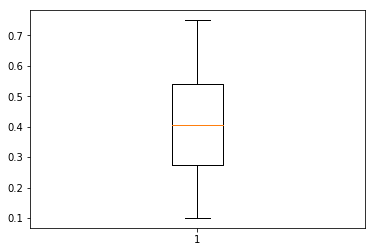

In [121]:
plt.boxplot(dataframe["rating"])
plt.show()

In [124]:
dataframe["length"].unique()

array([9, 5])